
# Section 5: Learning from only one sample: simple siamese neural networks
## Video 1: Discussion on methods with one sample (intro dataset)

Download the dataset here: https://github.com/brendenlake/omniglot

In [1]:
import sys
import numpy as np
from scipy.misc import imread
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Set logging dir for Tensorboard
logging_dir_n = 0

data_path = "datasets/omniglot/python/"
train_path = os.path.join(data_path,'images_background')
validation_path = os.path.join(data_path,'images_evaluation')

def load_images_from_directory(path,n=0):
    X=[]
    
    ## We load every alphabet seperately and append that to one tensor
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        alphabet_path = os.path.join(path,alphabet)
        
        ## Each character in alphabet is in a separate folder
        for letter in os.listdir(alphabet_path):
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
      
            if not os.path.isdir(letter_path):
                continue

            ## Read every image in this directory
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
            
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
    
    X = np.stack(X)
    return X

print("Loading training set")
Xtrain = load_images_from_directory(train_path)
print(Xtrain.shape)

print("Now loading evaluation set")
Xval = load_images_from_directory(validation_path)
print(Xval.shape)

Loading training set
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Japanese_(hiragana)
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Latin
loading alphabet: Greek
loading alphabet: Japanese_(katakana)
loading alphabet: Grantha
loading alphabet: N_Ko
loading alphabet: Balinese
loading alphabet: Tagalog
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Futurama
loading alphabet: Tifinagh
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Gujarati
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Cyrillic
loading alphabet: Sanskrit
loading alphabet: 

In [2]:
import numpy.random as rng

def get_batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    ## Initialise data we return in memory
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    ## Make a target vector with half same and half other categories
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    ## Pick the categories of characters we will return
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    for i in range(batch_size):
        category = categories[i]
        
        ## Choose two indixes from the amount of examples (20) we have
        idx_1 = rng.randint(0, n_examples)
        idx_2 = rng.randint(0, n_examples)
        
        #pick images of same class for 1st half, different for 2nd
        if targets[i] == 1:
            category_2 = category # if target is set: pick from same category
        else:
            ## Pick new class by picking random number 
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[0][i,:,:,:] = data[category,idx_1].reshape(w,h,1)
        pairs[1][i,:,:,:] = data[category_2,idx_2].reshape(w,h,1)
  
    return pairs, targets


def make_oneshot_task(data, N):
    n_val, n_ex_val, w, h = data.shape

    categories = rng.choice(n_val,size=(N,),replace=False)
    true_category = categories[0]
    
    indices = rng.randint(0, n_ex_val,size=(N,))
    
    ex1, ex2 = rng.choice(n_ex_val,replace=False,size=(2,))
    
    ## Create a list with the same image N times as test image
    test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    
    support_set = data[categories,indices,:,:]
    
    ## Create the targets and fill in true character
    targets = np.zeros((N,))    
    targets[0] = 1 # Set the first target to be the true character
    support_set[0,:,:] = data[true_category,ex2] # Fill in this caracter
    
    
    ## Reshape the data and return it
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image,support_set]
    return pairs, targets

### Visualising the characters.

2


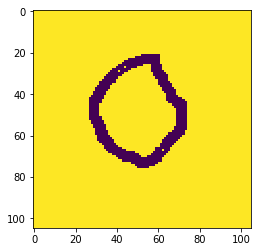

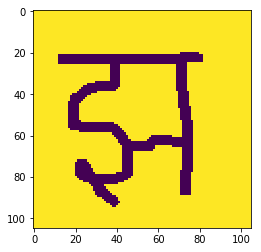

Is the same: 0.0


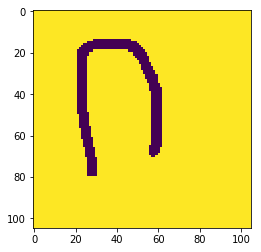

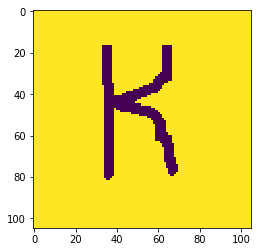

Is the same: 0.0


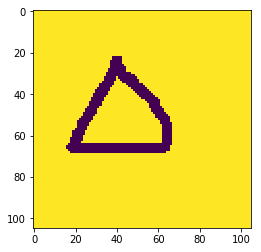

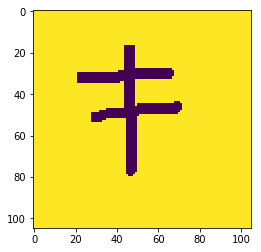

Is the same: 0.0


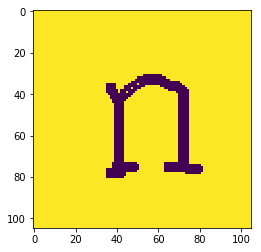

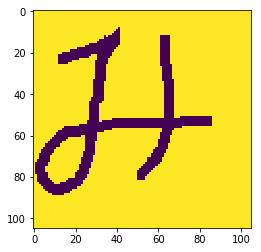

Is the same: 0.0


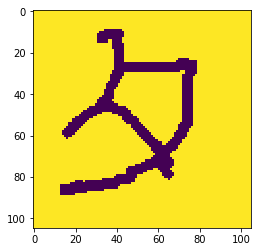

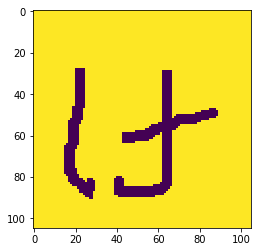

Is the same: 0.0


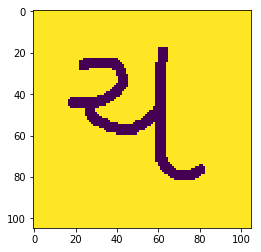

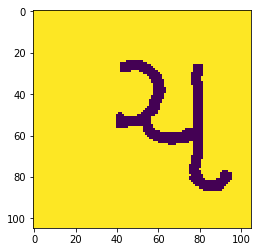

Is the same: 1.0


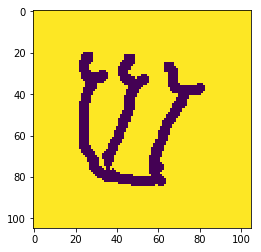

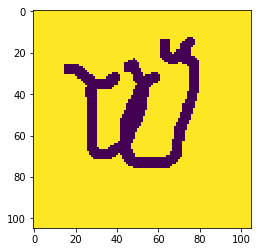

Is the same: 1.0


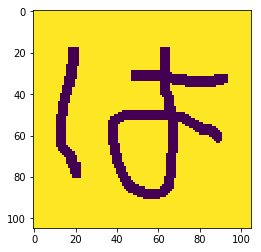

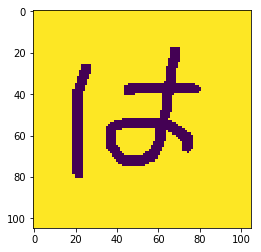

Is the same: 1.0


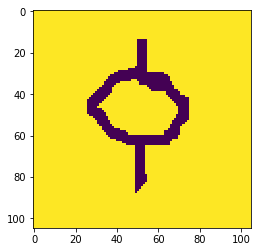

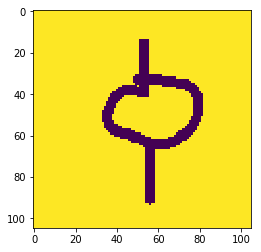

Is the same: 1.0


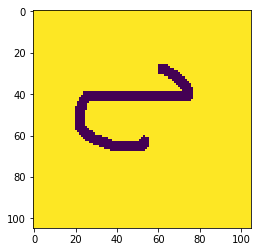

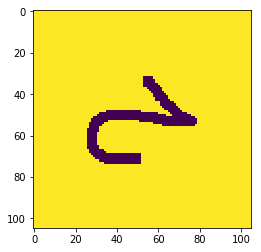

Is the same: 1.0


In [3]:
pairs, targets = get_batch(Xtrain, 10)
print(len(pairs))
for i in range(len(pairs[0])):

    #print(pairs[0][i].shape)    
    image = np.reshape(pairs[0][i],(105,105))
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()
    print("Is the same: " + str(targets[i]))


## Video 2: What is a siamese neural network?
Now imagine what you would have to do to train a neural network to recognise these images. We could try to have 1623 output neurons of our network, and train it on the data that we have. Now we only have 20 characters as example per image (and less after we split train and test set), so it will be very difficult to train this. 

Instead we take a different approach: we ask our network: are these two images the same character? It's like asking a human: are these two the same person? 
![arnold1](https://upload.wikimedia.org/wikipedia/commons/d/d4/Arnold_Schwarzenegger_February_2015.jpg)
![arnold2](https://c1.staticflickr.com/1/450/19869372178_6bf3dc0a10_b.jpg)

Training a neural network to recognise every human being on the planet is downright impossible, but we could train it to indicate if two images are the same or not. 

In a siamese neural network we perform this task by making a neural network that maps input to an output vector. The idea is that this neural network maps the same charater to the same output vector every time. 

There are a lot of interesting things about this neural network: 
- The layers are shared during training
- You only need a dataset with characters either marked "the same" and "different"
- This neural network then works with similar data the network never saw before!

To actually build this neural network we are going to define a function that returns the layers of the input part of the network. Note that we use the variable scope to AND structure this nicely in Tensorboard, AND so we can reuse the layers we built earlier...

In [35]:


def get_input_pipeline(x_input, is_training, reuse):
    
    tf.summary.image('image_in'+str(reuse), x_input)
    
    with tf.variable_scope("first_part", reuse=reuse):
#         conv1 = tf.layers.conv2d(x_input, 64, [10, 10], name='conv1', activation=tf.nn.relu, padding="same")
#         maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
#         drop1  = tf.layers.dropout(maxp1, training=is_training)
#         conv2 = tf.layers.conv2d(drop1, 128, [5, 5], name='conv2', activation=tf.nn.relu, padding="same")
#         maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
#         drop2  = tf.layers.dropout(maxp2, training=is_training)
#         conv3 = tf.layers.conv2d(drop2, 128, [3, 3], name='conv3', activation=tf.nn.relu, padding="same")
#         maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')

#         drop3  = tf.layers.dropout(maxp3, training=is_training)
#         conv4 = tf.layers.conv2d(drop3, 256, [3, 3], name='conv4', activation=tf.nn.relu)
#         maxp4 = tf.layers.max_pooling2d(conv4, (2,2),(2,2), name='maxp4')
        
#         drop4  = tf.layers.dropout(maxp4, training=is_training)
#         conv5 = tf.layers.conv2d(maxp4, 512, [3, 3], name='conv5', activation=tf.nn.relu)
    
#         flattened = tf.contrib.layers.flatten(conv5)
        
#         print(flattened) # Print so we know if this is a reasonable size for this flattened layer
        
#         drop5  = tf.layers.dropout(flattened, training=is_training)
#         dense1 = tf.layers.dense(drop5, 4096, activation=tf.nn.sigmoid, name="dense1")



        resized_image = tf.image.resize_images(x_input, (28,28))
        tf.summary.image('resized_image'+str(reuse), resized_image)
#         conv1 = tf.layers.conv2d(resized_image, 64, [5, 5], name='conv1', activation=tf.nn.relu, padding="same")
#         maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
#         drop1  = tf.layers.dropout(maxp1, training=is_training)
#         conv2 = tf.layers.conv2d(drop1, 128, [3, 3], name='conv2', activation=tf.nn.relu, padding="same")
#         maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
#         drop2  = tf.layers.dropout(maxp2, training=is_training)
#         conv3 = tf.layers.conv2d(drop2, 128, [3, 3], name='conv3', activation=tf.nn.relu, padding="same")
#         maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')
#         print(maxp3)
#         drop3  = tf.layers.dropout(maxp3, training=is_training)
#         conv4 = tf.layers.conv2d(drop3, 256, [3, 3], name='conv4', activation=tf.nn.relu)

        flattened = tf.contrib.layers.flatten(resized_image)
        
        print(flattened) # Print so we know if this is a reasonable size for this flattened layer
        
        dense01 = tf.layers.dense(flattened, 1024, activation=tf.nn.relu, name="dense01")
        dense02 = tf.layers.dense(dense01, 2048, activation=tf.nn.relu, name="dense02")
        dense03 = tf.layers.dense(dense02, 1024, activation=tf.nn.relu, name="dense03")
        
        dense1 = tf.layers.dense(dense03, 512, activation=tf.nn.sigmoid, name="dense1")
        
    return dense1


tf.reset_default_graph()
is_training_phase = tf.placeholder(dtype=tf.bool)
image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image1")
image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image2")
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1], name="labels")

out_1 = get_input_pipeline(image1, is_training_phase, None)
out_2 = get_input_pipeline(image2, is_training_phase, True)
print([x.name for x in tf.global_variables()])

writer = tf.summary.FileWriter(logdir='graphs/siamese_start', graph=tf.get_default_graph())


Tensor("first_part/Flatten/Reshape:0", shape=(?, 784), dtype=float32)
Tensor("first_part_1/Flatten/Reshape:0", shape=(?, 784), dtype=float32)
['first_part/dense01/kernel:0', 'first_part/dense01/bias:0', 'first_part/dense02/kernel:0', 'first_part/dense02/bias:0', 'first_part/dense03/kernel:0', 'first_part/dense03/bias:0', 'first_part/dense1/kernel:0', 'first_part/dense1/bias:0']


### Combining outputs by this network, and determining the loss
After we determined the output of our shared network part we have to see how well they match. To do this we can take the so-called "L1-distance", which is simply the absolute of output 1 minus output 2. Of course not every difference we get here has the same importance when determining if two images are the same. This is why we add a last dense layer that will indicate if two vectors are equal or not...

In [36]:
l_one = tf.abs(tf.subtract(out_1,out_2))
print(l_one)

prediction = tf.layers.dense(l_one, 1, activation=tf.nn.sigmoid, name="output")

Tensor("Abs:0", shape=(?, 512), dtype=float32)


In [37]:

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.9

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10, 0.99, staircase=True)


mseloss = tf.losses.mean_squared_error(label_placeholder,prediction)

epsilon = 0.00001
clipped_pred = tf.clip_by_value(prediction,epsilon,1-epsilon,name="clippingtool")
log_true = -tf.log(clipped_pred)
log_false = -tf.log(1-clipped_pred)

logloss = tf.multiply(label_placeholder,log_true) + tf.multiply(1-label_placeholder,log_false)
logloss = tf.reduce_mean(logloss)


#loss = thesis_crossentropy(label_placeholder, prediction)
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder, logits=prediction))
# loss = my_crossentropy(label_placeholder, prediction)
#loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=label_placeholder, logits=prediction))

# testloss = tf.identity(loss, name="testlossvec")
training_summary = tf.summary.scalar('mseloss', mseloss)
logloss_summary = tf.summary.scalar('logloss', logloss)
lr_summary = tf.summary.scalar('learningrate', learning_rate)
# testing_summary = tf.summary.scalar('testloss', testloss)
merged = tf.summary.merge_all()

# #w = tf.get_variable_by_name("first_part/conv1/kernel")
# a = [v for v in tf.global_variables()][0]

# histograms = []
# for v in tf.global_variables():
#     if "kernel" in v.name:
#         toadd = tf.summary.histogram(v.name[:-3], v)
#         histograms.append(toadd)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(mseloss, global_step=global_step)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(logloss, global_step=global_step)
#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(loss, global_step=global_step)
#optimizer = tf.train.AdamOptimizer().minimize(logloss, global_step=global_step)


## Video 3: Training and testing your network. 

https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

https://sorenbouma.github.io/blog/oneshot/

In [38]:
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1
writer.flush()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [39]:
#siam_loader = Siamese_Loader(Xtrain, Xval)
BATCH_SIZE = 64
for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets, is_training_phase: True})
    #print(l)
    writer.add_summary(summary, iteration)
#     eval_histos = sess.run(histograms)
#     for haatje in eval_histos:
#         writer.add_summary(haatje, iteration)
#     if iteration %10 == 0:
#         pairs, targets = get_batch(Xtrain, 6)
#         sp, pr = sess.run([sigpred, prediction], feed_dict={image1: pairs[0], image2: pairs[1]})
#         print("sigpred:")
#         print(sp)
#         print("prediction")
#         print(pr)
#         print("targets: ")
#         print(targets)
        
#         pairs, targets = get_batch(Xval, BATCH_SIZE)
#         targets = [[t] for t in targets]
#         _, m = sess.run([testloss, testing_summary], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
#         writer.add_summary(m, iteration)

In [28]:

## Determine the accuracy 
CHOOSE_FROM_N = 5
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    #inputs, targets = siam_loader.make_oneshot_task(CHOOSE_FROM_N)
    
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1], is_training_phase: False})
    #print(pred)
    #print(targets)
    maxindex = np.argmax(pred)

    if maxindex == 0:
        correct_tested += 1
print(correct_tested/TEST_COUNT)


0.20333333333333334


In [ ]:
## DEBUG FUCKING FUNCTIE

pairs, targets = siam_loader.get_batch(2)
newt = list()
for t in targets:
    if t == 1:
        newt.append([0,1])
    else:
        newt.append([1,0])

l, o1, o2, pred = sess.run([loss, out_1, out_2, prediction], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: newt})

print(l)
print(pred)

In [ ]:
print(pred)
print(o1)
print(o2)

In [ ]:
pairs, targets = siam_loader.get_batch(BATCH_SIZE)
targets = [[t] for t in targets]
_, l, summary = sess.run([optimizer, loss, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
print(l)
writer.add_summary(summary, iteration)

In [ ]:
pairs, targets = siam_loader.get_batch(1)
targets = [[t] for t in targets]
a1, a2 = sess.run([out_1, out_2], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
print(a1)
print(a2)

In [ ]:
pairs, targets = siam_loader.get_batch(6)
targets = [[t] for t in targets]
pred = sess.run(prediction, feed_dict={image1: pairs[0], image2: pairs[1]})
for index in range(len(targets)):
    print(index)
    print(pred[index])
    print(targets[index])
    im = np.reshape(pairs[0][index], (105, 105))
    plt.imshow(im)
    plt.show()
    im2 = np.reshape(pairs[1][index], (105, 105))
    plt.imshow(im2)
    plt.show()
    


In [ ]:
inputs, targets = siam_loader.make_oneshot_task(5)
# print(len(inputs))
# print(len(targets))
# print(inputs[0].shape)
# print(inputs[1].shape)
# print(targets.shape)


pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
print(np.argmax(pred))

# print(pred)
# print(targets)

maxindex = np.argmax(pred)
if maxindex == 0:
    print("Correct")
else:
    print("Incorrect")
im = np.reshape(inputs[0][maxindex], (105, 105))
plt.imshow(im)
plt.show()

im = np.reshape(inputs[1][maxindex], (105, 105))
plt.imshow(im)
plt.show()


# for index in range(len(targets)):
#     im = np.reshape(inputs[0][index], (105, 105))
#     plt.imshow(im)
#     plt.show()
#     im = np.reshape(inputs[1][index], (105, 105))
#     plt.imshow(im)
#     plt.show()
#     print(pred[index][0])
#     print(targets[index])
